In [1]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
import time
from datetime import datetime
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
import tensorflow_hub as hub
from skimage.transform import resize
from scipy.misc import imresize
from contextlib import contextmanager
import shutil

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True
TEST = True

# NOTES
NOTES = "mobilenetv2-96"

# Vars
target_label = "label"
id_label = "ImageId"
RESET_ALL = True
TYPE = "TLNN"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
#TFHUB_MODULE = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/classification/1"
TFHUB_MODULE = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/1"
BOTTLENECK_DIR = '/tmp/bottlenecks/'
BOTTLENECK_TRAIN_DIR = '/tmp/bottlenecks/train/'
BOTTLENECK_EVAL_DIR = '/tmp/bottlenecks/eval/'

if TEST:
    LEARNING_STEPS = 1000
    LEARNING_RATE = 0.01
    BATCH_SIZE = 50
    VERBOSITY = 100
    LOG_STEP = 25
    test_size = 200
else:
    LEARNING_STEPS = 2000
    LEARNING_RATE = 0.01
    BATCH_SIZE = 100
    VERBOSITY = 1000
    LOG_STEP = 100

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/sample_submission.csv",
    "Checkpoints":"/tmp/checkpoints/",
    "Digits":"/tmp/checkpoints/Digits/"
}

In [2]:
def nearest_2(n):
    if n < 1:
        return 1
    l = int(math.log(n, 2))
    a, b = 2 ** l, 2 ** (l + 1)
    return (a if (n - a) <= (b - n) else b)

def display(img, w, h):
    one_image = img.reshape(w,h)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()
    
def reset_dirs(dirs = [BOTTLENECK_DIR, BOTTLENECK_TRAIN_DIR, BOTTLENECK_EVAL_DIR, paths["Checkpoints"], paths["Digits"]]):
    for p in dirs:
        if os.path.isdir(p):
            shutil.rmtree(p)
    for p in dirs:
        if not os.path.isdir(p):
            os.mkdir(p)

def timer(f, *args):
    print("Start <{}>: ".format(f.__name__), datetime.now())
    start = time.time()
    result = f(*args)
    end = time.time()
    print("End: ", datetime.now())
    seconds = end - start
    days = int(seconds // (60 ** 3))
    hours = int((seconds % (60 ** 3)) // (60 ** 2))
    minutes = int((seconds % (60 ** 2)) // 60)
    seconds %= 60
    if days > 0:
        print("Finished in {:02}:{:02}:{:02}:{:07.4f}".format(days, hours, minutes, seconds))
    if hours > 0:
        print("Finished in {:02}:{:02}:{:07.4f}".format(hours, minutes, seconds))
    if minutes > 0:
        print("Finished in {:02}:{:07.4f}".format(minutes, seconds))
    else:
        print("Finished in {} seconds".format(seconds))
    return result

def add_img_decoding(module_spec):                                       
    input_height, input_width = hub.get_expected_image_size(module_spec)
    input_depth = hub.get_num_image_channels(module_spec)
    img_data = tf.placeholder(tf.int32, name='DecodeImgInput')
    decoded_image = tf.image.grayscale_to_rgb(img_data)
    # Convert from full range of uint8 to range [0,1] of float32.
    decoded_image_as_float = tf.image.convert_image_dtype(decoded_image, tf.float32)
    decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
    resize_shape = tf.stack([input_height, input_width])
    resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
    resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
    return img_data, resized_image

def process_bottlenecks(df, bdir):
    with tf.Session(graph=graph) as sess:
        # Initialize all weights: for the module to their pretrained values,
        # and for the newly added retraining layer to random initial values.
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # Set up the image decoding sub-graph.
        image_data_tensor, decoded_image_tensor = add_img_decoding(module_spec)

        # Compute bottleneck features.
        for index, row in df.iterrows():
            bottleneck_path = os.path.join(bdir, str(index) + '.txt')
            if not os.path.exists(bottleneck_path):
                image_data = np.asarray(row, dtype=np.int32)
                image_data.shape = (28, 28, 1)
                if (index + 1) % VERBOSITY == 0:
                    print("\tCreated {}th bottleneck".format(index + 1))
                    display(image_data, 28, 28)
                try:
                    # First resize it, and rescale the pixel values.
                    resized_input_values = sess.run(decoded_image_tensor,
                                                    {image_data_tensor: image_data})
                    # Then run it through the module
                    bottleneck_values = sess.run(bottleneck_tensor,
                                                 {resized_input_tensor: resized_input_values})
                    bottleneck_values = np.squeeze(bottleneck_values)
                except Exception as e:
                    raise RuntimeError('Error during processing image index %s (%s)' % (index,
                                                                                 str(e)))
                bottleneck_string = ','.join(str(x) for x in bottleneck_values)
                with open(bottleneck_path, 'w') as bottleneck_file:
                    bottleneck_file.write(bottleneck_string)
            else:
                if (index + 1) % VERBOSITY == 0:
                    print("\tRead {}th bottleneck".format(index + 1))

def make_new_dataframe_from_bottlenecks(bdir):
    bottlenecked_data = pd.DataFrame()
    counter = 1
    for file in os.listdir(bdir):
        if counter % VERBOSITY == 0:
            print("\tProcessed {}th bottleneck".format(counter))
        counter += 1
        new = pd.read_csv(os.path.join(bdir, file), sep=",", header=None)
        new.index = [int(file[:-4])]
        #print("NEW: ", new)
        bottlenecked_data = pd.concat([bottlenecked_data, new])
    return bottlenecked_data

In [3]:
def display(img, w, h):
    one_image = img.reshape(w,h)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()

def mobilenet_model_fn(features, labels, mode):
    logits = tf.layers.dense(inputs=features, units=10)
    saver = tf.train.Saver()
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
# TF Hub setup
module_spec = hub.load_module_spec(TFHUB_MODULE)
height, width = hub.get_expected_image_size(module_spec)
with tf.Graph().as_default() as graph:
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec)
    bottleneck_tensor = m(resized_input_tensor)

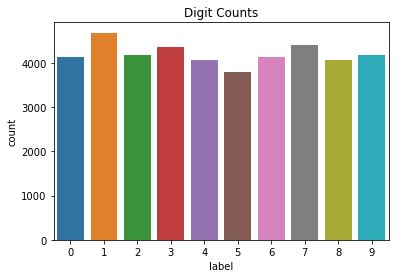

In [5]:
# Read in the raw data
train_data = pd.read_csv(paths["Training"], sep=",").astype(np.int32)

# Make some purdy pictures
ax = sns.countplot(x="label", data=train_data)
ax.set_title("Digit Counts")
plt.show()

# Setup labels and eval data
train_labels = train_data.pop("label")
eval_data = pd.read_csv(paths["Testing"], sep=",").astype(np.int32)
eval_labels = pd.read_csv(paths["Submission"], sep=",").astype(np.int32).pop("Label")

# Setup for TEST mode
if TEST: # this occurs BEFORE randomization! This assumes that the input is uniformly distributed. Plan accordingly
    train_data = train_data.head(test_size)
    train_labels = train_labels.head(test_size)
    eval_data = eval_data.head(test_size)
    eval_labels = eval_labels.head(test_size)

# Reset the directories, if necessary
if RESET_ALL:
    reset_dirs()

Making Training and Validation Bottlenecks
Start <process_bottlenecks>:  2018-07-04 19:16:38.437492
	Created 100th bottleneck


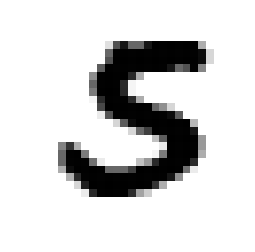

	Created 200th bottleneck


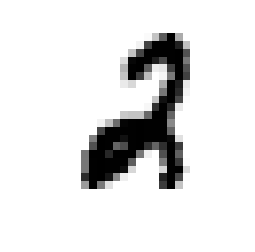

End:  2018-07-04 19:16:45.491314
Finished in 7.053462505340576 seconds

Making Evaluation/Testing Bottlenecks
Start <process_bottlenecks>:  2018-07-04 19:16:45.492548
	Created 100th bottleneck


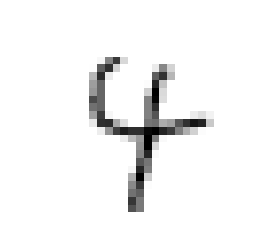

	Created 200th bottleneck


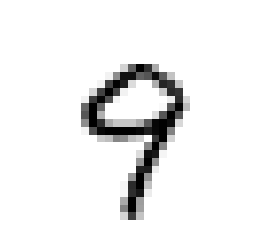

End:  2018-07-04 19:16:51.953438
Finished in 6.460651397705078 seconds


In [6]:
# Pre-calculate bottlenecks
print("Making Training and Validation Bottlenecks")
timer(process_bottlenecks, train_data, BOTTLENECK_TRAIN_DIR)
print("\nMaking Evaluation/Testing Bottlenecks")
timer(process_bottlenecks, eval_data, BOTTLENECK_EVAL_DIR)

In [7]:
# Build a dataframe from the bottleneck values
print("Making bottlenecked training dataset")
train_data = timer(make_new_dataframe_from_bottlenecks, BOTTLENECK_TRAIN_DIR)
print("\nMaking bottlenecked evaluation dataset")
eval_data = timer(make_new_dataframe_from_bottlenecks, BOTTLENECK_EVAL_DIR)

Making bottlenecked training dataset
Start <make_new_dataframe_from_bottlenecks>:  2018-07-04 19:16:51.962512
	Processed 100th bottleneck
	Processed 200th bottleneck
End:  2018-07-04 19:17:00.097076
Finished in 8.134432315826416 seconds

Making bottlenecked evaluation dataset
Start <make_new_dataframe_from_bottlenecks>:  2018-07-04 19:17:00.097799
	Processed 100th bottleneck
	Processed 200th bottleneck
End:  2018-07-04 19:17:08.414057
Finished in 8.316095113754272 seconds


In [8]:
# Shuffle the training and validation data
idx = np.random.permutation(train_data.index)
train_data = train_data.reindex(idx)
train_labels = train_labels.reindex(idx)

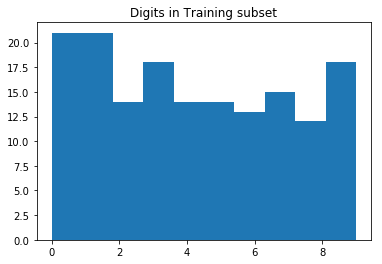

In [9]:
# Make a validation set from the training data (80/20)
train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)
eval_data = np.asarray(eval_data)
t_size = int(0.8 * train_data.shape[0])
validation_labels = train_labels[t_size:]
train_labels = train_labels[:t_size]
validation_data = train_data[t_size:]
train_data = train_data[:t_size]

# Plot the remaining labels to check for relatively uniform distribution
plt.hist(train_labels)
plt.title("Digits in Training subset")
plt.show()

In [10]:
# Sanity check on the data
print("TRAINING DATA")
print(train_data.shape, type(train_data))
print(train_data)
print("-" * 40, "\nTRAINING LABELS")
print(train_labels.shape, type(train_labels), train_labels.dtype)
print("-" * 40, "\nVALIDATION DATA")
print(validation_data.shape, type(validation_data))
print(validation_data)
print("-" * 40, "\nVALIDATION LABELS")
print(validation_labels.shape, type(validation_labels), validation_labels.dtype)
print("-" * 40, "\nEVALUATION DATA")
print(eval_data.shape, type(eval_data))
print("-" * 40, "\nEVALUATION LABELS")
print(eval_labels.shape, type(eval_labels), eval_labels.dtype)
print(eval_labels)
print(set(eval_labels))

TRAINING DATA
(160, 1280) <class 'numpy.ndarray'>
[[ 0.        0.466443  0.604599 ...,  0.        0.13084   0.      ]
 [ 0.        0.466445  0.6046   ...,  0.        0.130841  0.      ]
 [ 0.        0.466442  0.604599 ...,  0.        0.130839  0.      ]
 ..., 
 [ 0.        0.466443  0.604599 ...,  0.        0.13084   0.      ]
 [ 0.        0.466443  0.604599 ...,  0.        0.130839  0.      ]
 [ 0.        0.466443  0.604596 ...,  0.        0.130839  0.      ]]
---------------------------------------- 
TRAINING LABELS
(160,) <class 'numpy.ndarray'> int32
---------------------------------------- 
VALIDATION DATA
(40, 1280) <class 'numpy.ndarray'>
[[ 0.        0.466442  0.604594 ...,  0.        0.130838  0.      ]
 [ 0.        0.466442  0.604598 ...,  0.        0.130838  0.      ]
 [ 0.        0.466444  0.604596 ...,  0.        0.130839  0.      ]
 ..., 
 [ 0.        0.466441  0.604598 ...,  0.        0.13084   0.      ]
 [ 0.        0.466442  0.604599 ...,  0.        0.130841  0.      ]

In [11]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=mobilenet_model_fn, model_dir=paths["Checkpoints"])

In [12]:
# Create Input Functions for the three modes
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_data,
    y=train_labels,
    batch_size=BATCH_SIZE,
    num_epochs=None,
    shuffle=True)

training_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_data,
    y=train_labels,
    num_epochs=1,
    shuffle=False)

validation_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=validation_data,
    y=validation_labels,
    num_epochs=1,
    shuffle=False)

In [13]:
# Train the model
logging_hook = tf.train.LoggingTensorHook({"loss" : "loss"}, every_n_iter=10)
periods = LEARNING_STEPS // 100
steps_per_period = LEARNING_STEPS // periods
t_accs = []
v_accs = []
t_lls = []
v_lls = []
print("Training model...\nMetrics:")
print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
for period in range(periods):
    classifier.train(
        input_fn=train_input_fn,
        steps=steps_per_period,
        hooks=[logging_hook])
    training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
    validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
    t_ll = training_stats["loss"]
    t_acc = 100 * training_stats["accuracy"]
    v_ll = validation_stats["loss"]
    v_acc = 100 * validation_stats["accuracy"]
    print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, t_ll, v_ll))
    print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
    t_lls.append(t_ll);
    v_lls.append(v_ll)
    t_accs.append(t_acc)
    v_accs.append(v_acc)
accuracy = classifier.evaluate(input_fn=validation_eval_input_fn)["accuracy"] * 100

Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
	0	LgLs	2.29	2.38
		Acc.	11.25%	5.00%

	1	LgLs	2.31	2.41
		Acc.	13.12%	7.50%

	2	LgLs	2.32	2.37
		Acc.	11.25%	5.00%

	3	LgLs	2.29	2.40
		Acc.	13.12%	7.50%

	4	LgLs	2.28	2.43
		Acc.	13.12%	7.50%

	5	LgLs	2.33	2.34
		Acc.	8.75%	17.50%

	6	LgLs	2.30	2.33
		Acc.	11.25%	10.00%

	7	LgLs	2.35	2.32
		Acc.	8.75%	7.50%

	8	LgLs	2.32	2.39
		Acc.	8.75%	10.00%

	9	LgLs	2.32	2.36
		Acc.	13.12%	7.50%



Final accuracy (on validation data): 7.5000%


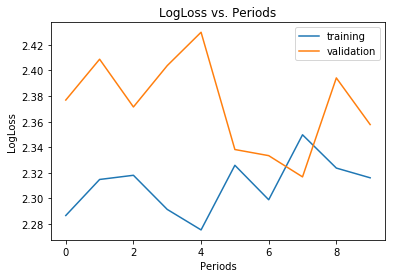

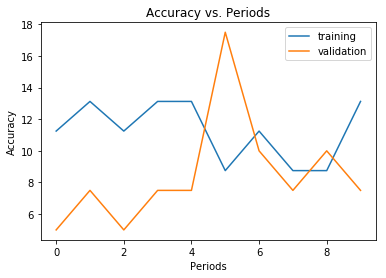

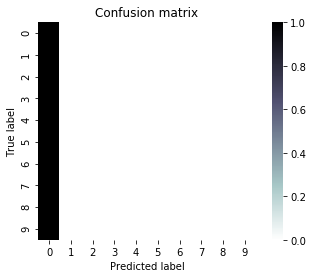

In [14]:
print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# Output a graph of loss metrics over periods.
plt.ylabel("LogLoss")
plt.xlabel("Periods")
plt.title("LogLoss vs. Periods")
plt.plot(t_lls, label="training")
plt.plot(v_lls, label="validation")
plt.legend()
plt.show()

# Output a graph of accuracy over periods.
plt.ylabel("Accuracy")
plt.xlabel("Periods")
plt.title("Accuracy vs. Periods")
plt.plot(t_accs, label="training")
plt.plot(v_accs, label="validation")
plt.legend()
plt.show()

# Output a plot of the confusion matrix.
predictions = np.array([item['classes'] for item in classifier.predict(input_fn=validation_eval_input_fn)])
cm = confusion_matrix(validation_labels, predictions)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class).
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm_normalized, cmap="bone_r")
ax.set_aspect(1)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [15]:
# Evaluate the model and print results
tf.logging.set_verbosity(tf.logging.INFO)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=eval_data,
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
stats = classifier.evaluate(input_fn=eval_input_fn)
t_accuracy = 100 * stats["accuracy"]
print("Accuracy on evaluation data (expected ~10%): {:.2f}%".format(t_accuracy))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-04-19:17:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/checkpoints/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-04-19:17:26
INFO:tensorflow:Saving dict for global step 1000: accuracy = 1.0, global_step = 1000, loss = 1.65675
Accuracy on evaluation data (expected ~10%): 100.00%


In [16]:
# Make Predictions and output the results
predictions = np.array([item['classes'] for item in classifier.predict(input_fn=eval_input_fn)])
ids = np.array([i + 1 for i in range(len(predictions))])
output = pd.DataFrame({id_label:ids, target_label:predictions}, dtype=np.int32)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/checkpoints/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [17]:
name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
print("Filename: '{}'".format(name))
if not TEST:
    output.to_csv(name, index=False)

Filename: 'A7.5000_TypeTLNN_LR0.01_S1000_B50_mobilenetv2-96.csv'
